In [1]:
import os,random
os.environ["KERAS_BACKEND"]="theano"
os.environ["THEANO_FLAGS"]="device=cuda"
#os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import matplotlib.pyplot as plt
import  random, sys, keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import _pickle as cPickle

Using Theano backend.
/root/anaconda3/envs/py37tf114/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7602 on context None
Mapped name None to device cuda: GeForce RTX 2070 SUPER (0000:01:00.0)


In [2]:
Xd = cPickle.load(open("/root/workspace/dataset/RML2014.04c_6db.dat",'rb'), encoding="latin1")
print("Dataset imported")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):
            lbl.append((mod,snr))

X = np.vstack(X)

Dataset imported


In [3]:
Xd_all = cPickle.load(open("/root/workspace/dataset/RML2014.04c_impulse_data.dat",'rb'), encoding="latin1")
print("Dataset imported")
snrs_all,mods_all = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd_all.keys())))), [1,0])
X_all = []  
lbl_all = []
for mod in mods_all:
    for snr in snrs_all:
        X_all.append(Xd_all[(mod,snr)])
        for i in range(Xd_all[(mod,snr)].shape[0]):
            lbl_all.append((mod,snr))

X_all = np.vstack(X_all)

Dataset imported


In [4]:
print("Dataset formatted into shape: ",X.shape)
# print out the snrs and mods
print("Dataset with SNRs: ",snrs)
print("Dataset with Modulations: ",mods)
print("Data prepared")


Dataset formatted into shape:  (4510, 2, 128)
Dataset with SNRs:  [6]
Dataset with Modulations:  ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Data prepared


In [5]:
print("Dataset formatted into shape: ",X_all.shape)
# print out the snrs and mods
print("Dataset with SNRs: ",snrs_all)
print("Dataset with Modulations: ",mods_all)
print("Data prepared")


Dataset formatted into shape:  (90200, 2, 128)
Dataset with SNRs:  [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Dataset with Modulations:  ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Data prepared


In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2017)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(list(yy)), max(list(yy),default=0)+1])
    yy1[np.arange(len(list(yy))),yy] = 1
    return yy1

Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [7]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2017)
n_examples_all = X_all.shape[0]
n_train_all = int(n_examples_all * 0.5)
train_idx_all = np.random.choice(range(0,n_examples_all), size=n_train_all, replace=False)
test_idx_all = list(set(range(0,n_examples_all))-set(train_idx_all))
X_train_all = X_all[train_idx_all]
X_test_all =  X_all[test_idx_all]
def to_onehot(yy):
    yy1 = np.zeros([len(list(yy)), max(list(yy),default=0)+1])
    yy1[np.arange(len(list(yy))),yy] = 1
    return yy1

Y_train_all = to_onehot(list(map(lambda x: mods_all.index(lbl_all[x][0]), train_idx_all)))
Y_test_all = to_onehot(list(map(lambda x: mods_all.index(lbl_all[x][0]), test_idx_all)))

In [8]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(2255, 2, 128) [2, 128]


In [9]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
dr = 0.5 # dropout rate (%)

model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (1,4), activation="relu"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(64, (2,4), activation="relu"))
model.add(Dropout(dr))
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
model.add(Conv2D(128, (1,8), activation="relu"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(len(classes), activation='softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 129, 64)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 129, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 133, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 130, 64)        32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 130, 64)       

In [10]:
# Train the dataset
#  and store the weights
filepath = 'weight_4layers.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])






Train on 2255 samples, validate on 2255 samples
Epoch 1/100
2255/2255 [==============================] - 1s 471us/step - loss: 2.3980 - accuracy: 0.0936 - val_loss: 2.3982 - val_accuracy: 0.0874
Epoch 2/100
2255/2255 [==============================] - 0s 122us/step - loss: 2.3970 - accuracy: 0.1016 - val_loss: 2.3989 - val_accuracy: 0.0874
Epoch 3/100
2255/2255 [==============================] - 0s 120us/step - loss: 2.3980 - accuracy: 0.1042 - val_loss: 2.3969 - val_accuracy: 0.0874
Epoch 4/100
2255/2255 [==============================] - 0s 122us/step - loss: 2.3935 - accuracy: 0.1029 - val_loss: 2.3881 - val_accuracy: 0.0860
Epoch 5/100
2255/2255 [==============================] - 0s 122us/step - loss: 2.3811 - accuracy: 0.0962 - val_loss: 2.3453 - val_accuracy: 0.1823
Epoch 6/100
2255/2255 [==============================] - 0s 122us/step - loss: 2.3326 - accuracy: 0.1330 - val_loss: 2.2667 - val_accuracy: 0.1911
Epoch 7/100
2255/2255 [==============================] - 0s 121us/step

In [11]:
score = model.evaluate(X_test,Y_test, verbose=1, batch_size=batch_size)
print(score)

2255/2255 [==============================] - 0s 24us/step
[0.7841516988636913, 0.6949002146720886]


In [12]:
score = model.evaluate(X_test_all,Y_test_all, verbose=1, batch_size=batch_size)
print(score)

45100/45100 [==============================] - 1s 23us/step
[5.012105823615173, 0.31869179010391235]


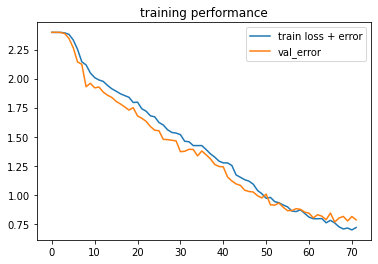

In [13]:
plt.figure()
plt.title('training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss + error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


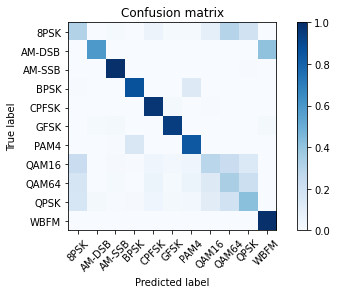

In [15]:

# Plot confusion matrix for the whole dataset
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


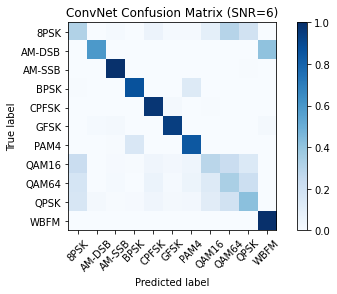

In [16]:
acc = {}
for snr in snrs:
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_MODs = list(map(lambda x: lbl[x][0], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

  # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])

    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%snr)
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)

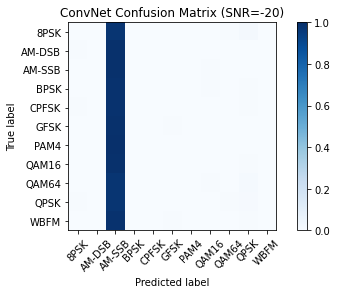

SNR :  -20 Overall Accuracy:  0.09475539885412076


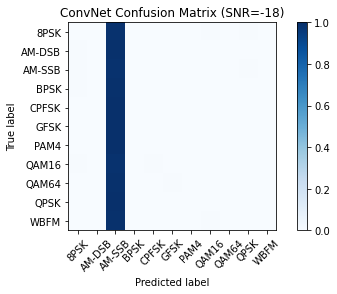

SNR :  -18 Overall Accuracy:  0.0897039328325232


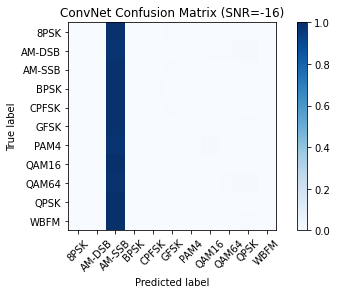

SNR :  -16 Overall Accuracy:  0.08730512249443208


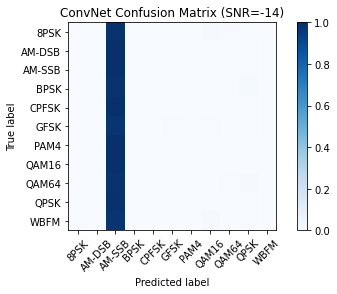

SNR :  -14 Overall Accuracy:  0.09667266187050359


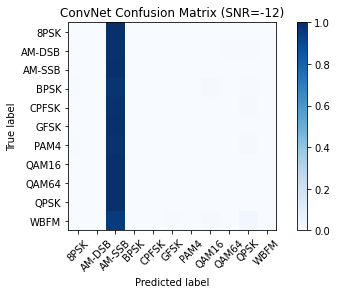

SNR :  -12 Overall Accuracy:  0.09025594970812753


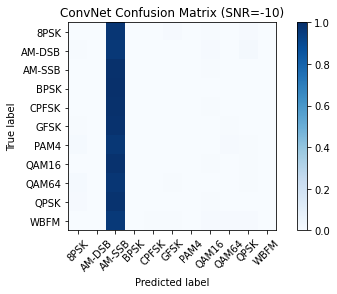

SNR :  -10 Overall Accuracy:  0.09449171518137035


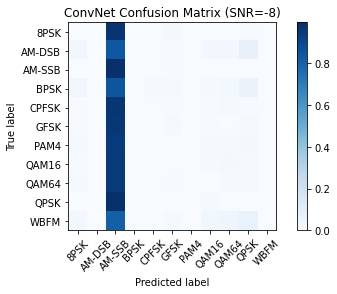

SNR :  -8 Overall Accuracy:  0.0925764192139738


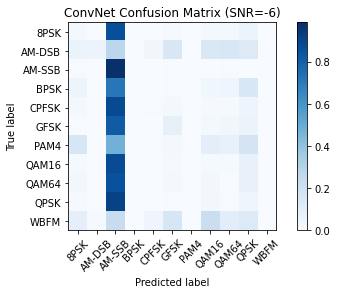

SNR :  -6 Overall Accuracy:  0.11027457927369354


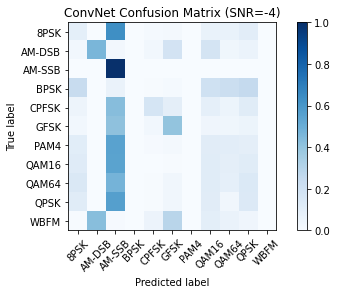

SNR :  -4 Overall Accuracy:  0.2339572192513369


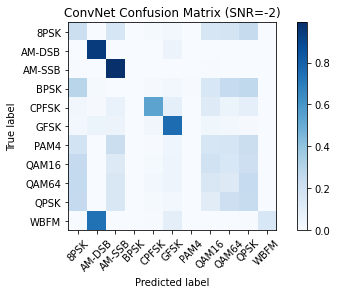

SNR :  -2 Overall Accuracy:  0.3824424163407214


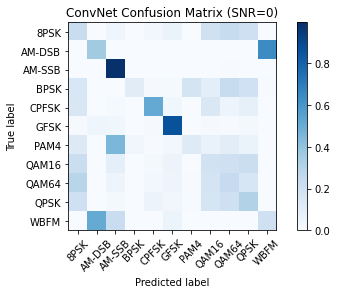

SNR :  0 Overall Accuracy:  0.37477148080438755


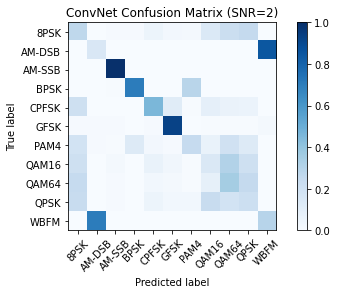

SNR :  2 Overall Accuracy:  0.4311091854419411


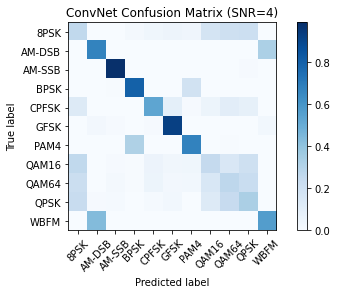

SNR :  4 Overall Accuracy:  0.5731814198071867


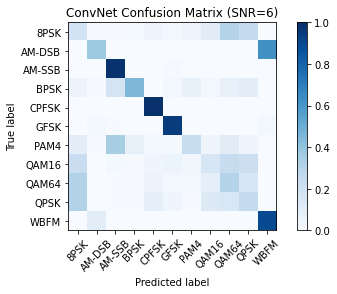

SNR :  6 Overall Accuracy:  0.5285588752196837


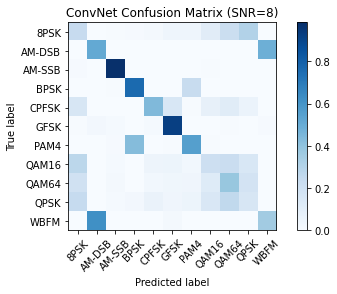

SNR :  8 Overall Accuracy:  0.5026857654431512


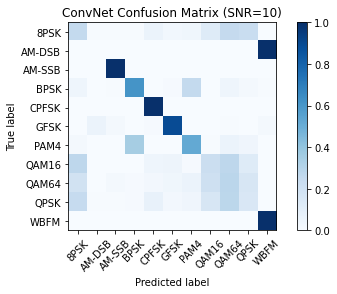

SNR :  10 Overall Accuracy:  0.5388459791004089


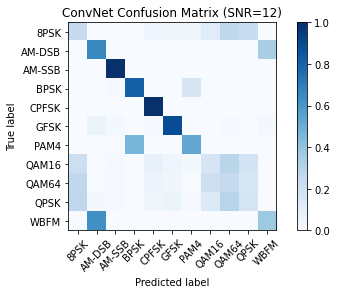

SNR :  12 Overall Accuracy:  0.5539947322212467


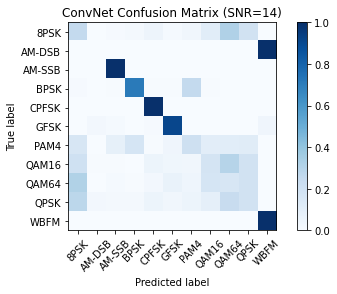

SNR :  14 Overall Accuracy:  0.5056028686687584


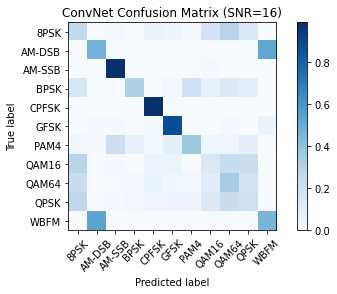

SNR :  16 Overall Accuracy:  0.4918032786885246


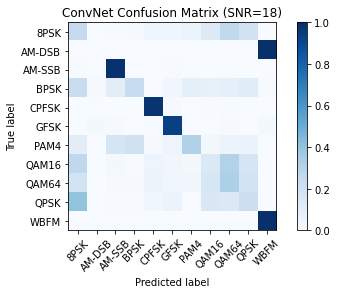

SNR :  18 Overall Accuracy:  0.4936708860759494


In [17]:
acc = {}
for snr in snrs_all:
    test_SNRs = list(map(lambda x: lbl_all[x][1], test_idx_all))
    test_MODs = list(map(lambda x: lbl_all[x][0], test_idx_all))
    test_X_i = X_test_all[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test_all[np.where(np.array(test_SNRs)==snr)]

  # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])

    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%snr)
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR : ",snr, "Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

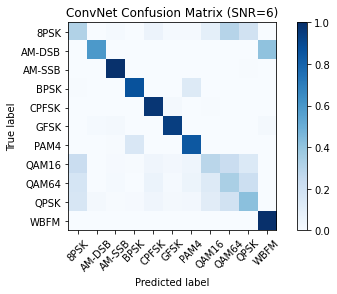

SNR :  6 Overall Accuracy:  0.6949002217294901


In [18]:
acc = {}
for snr in snrs:
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_MODs = list(map(lambda x: lbl[x][0], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

  # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])

    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%snr)
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR : ",snr, "Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

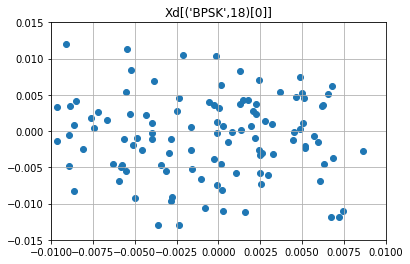

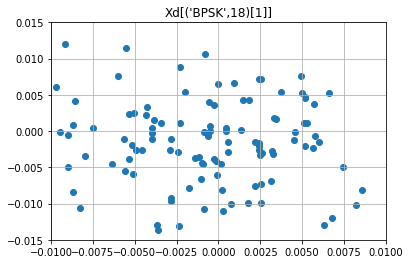

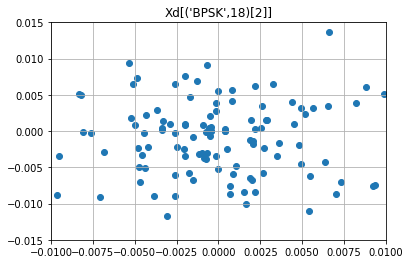

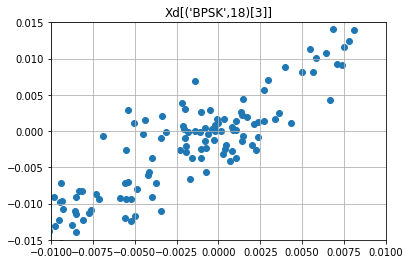

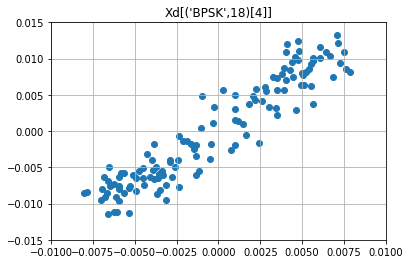

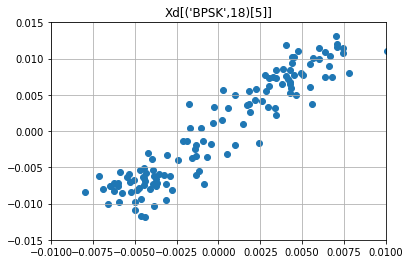

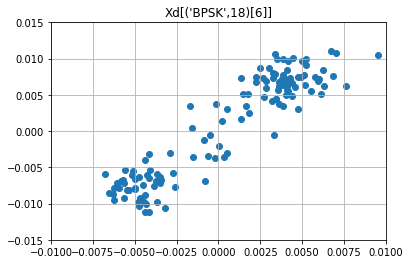

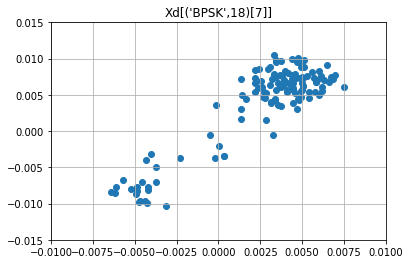

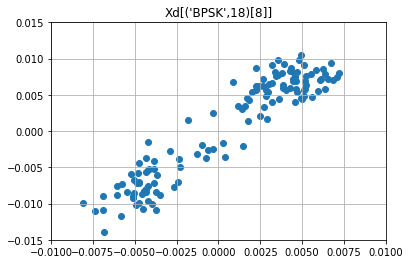

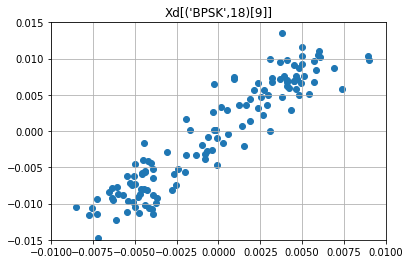

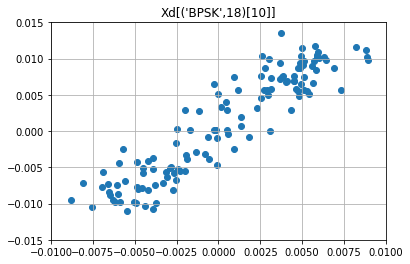

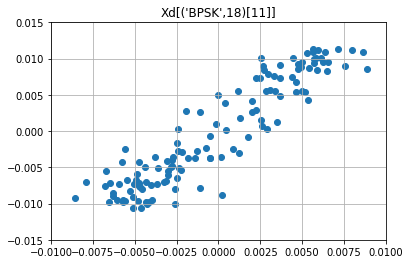

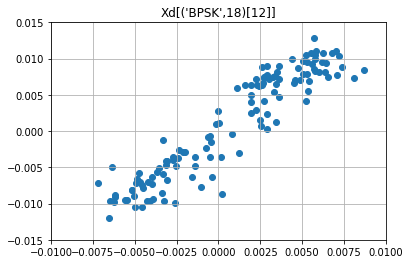

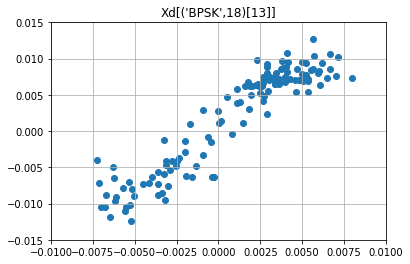

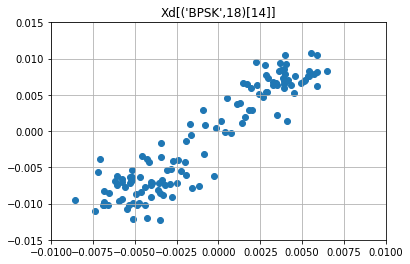

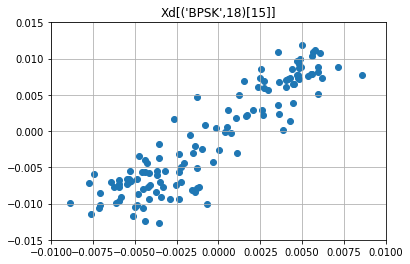

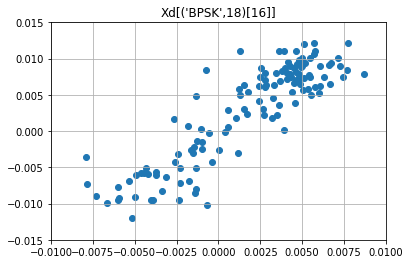

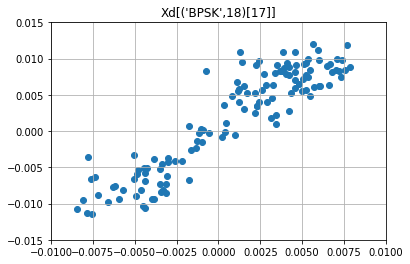

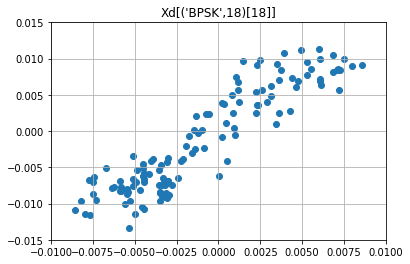

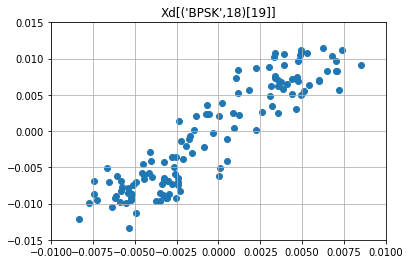

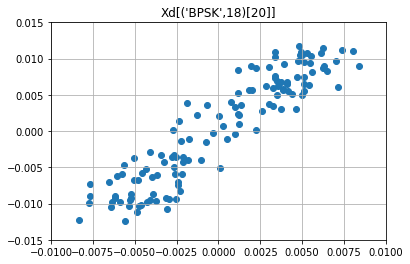

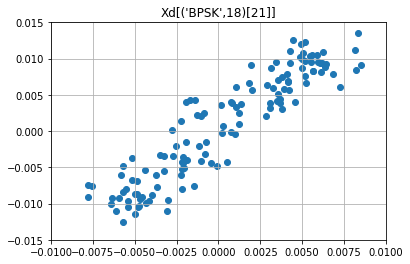

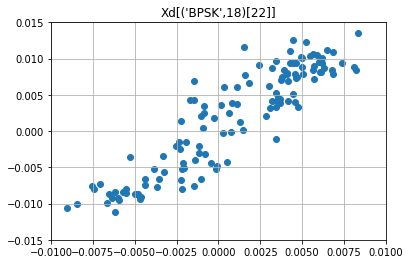

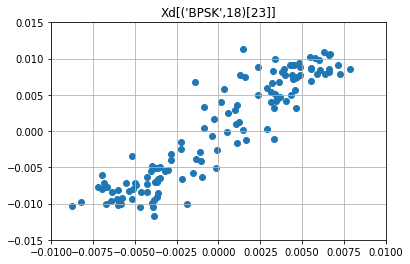

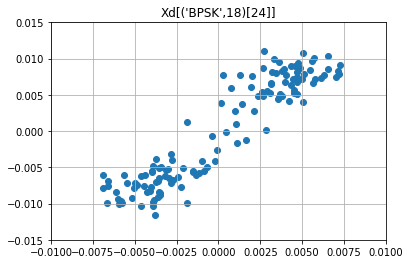

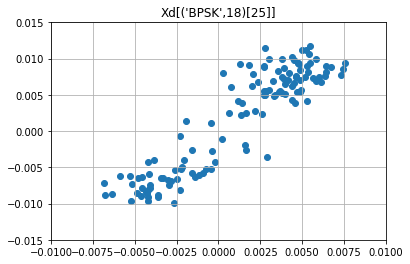

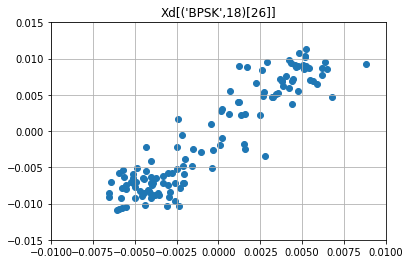

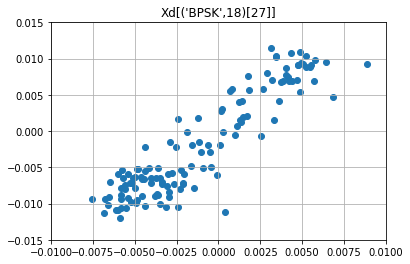

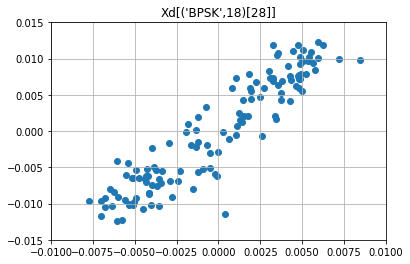

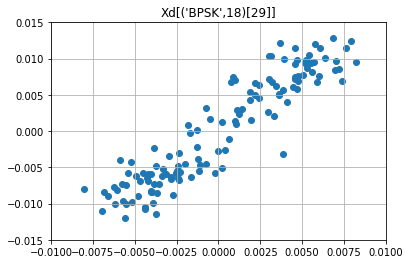

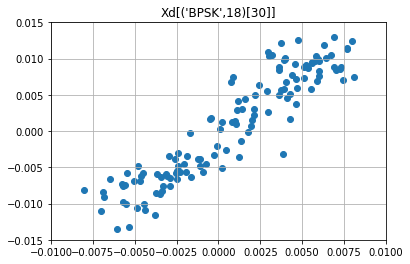

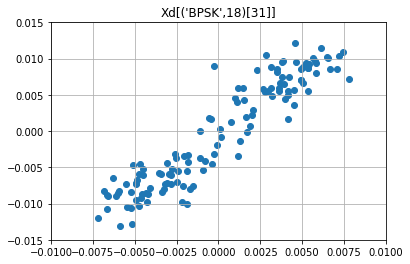

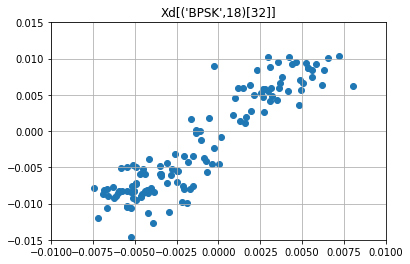

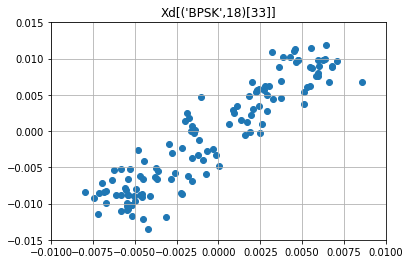

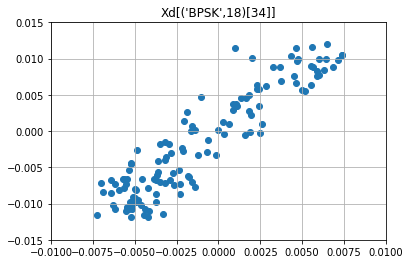

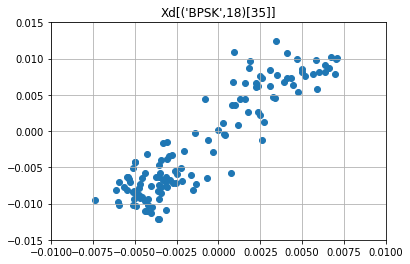

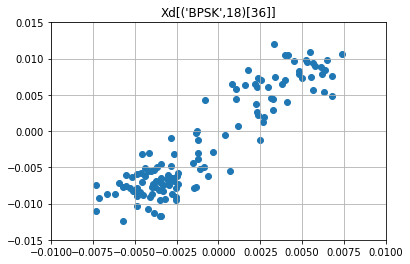

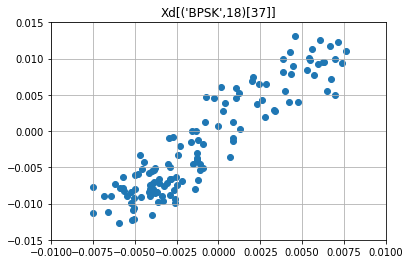

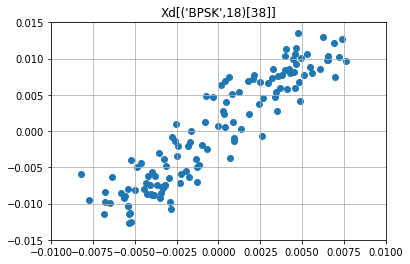

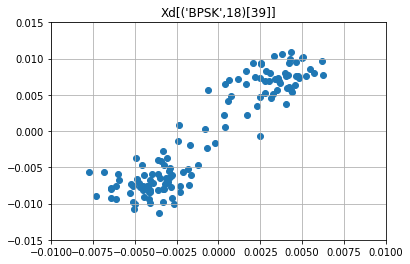

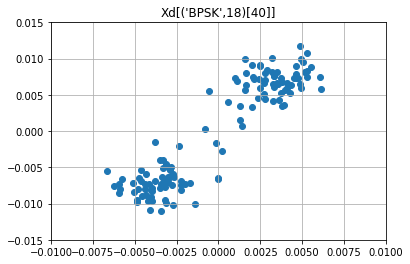

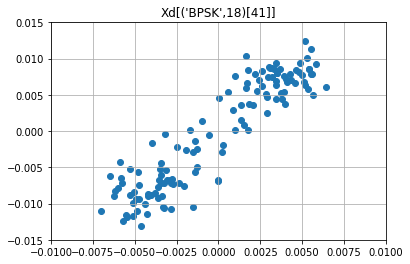

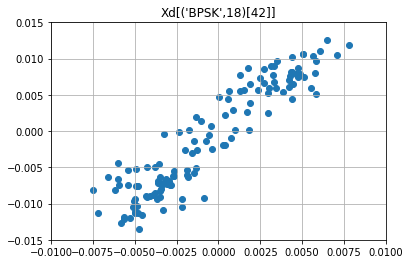

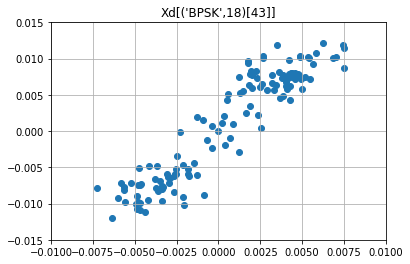

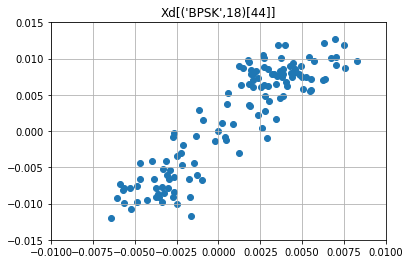

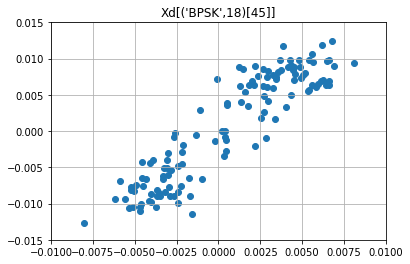

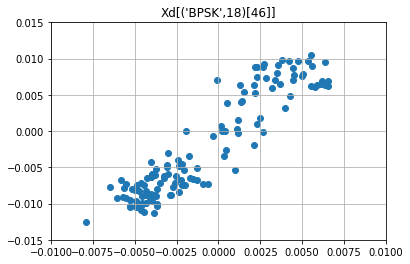

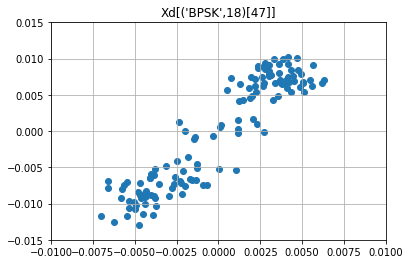

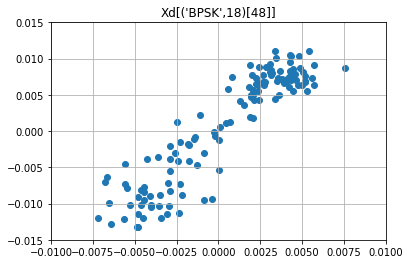

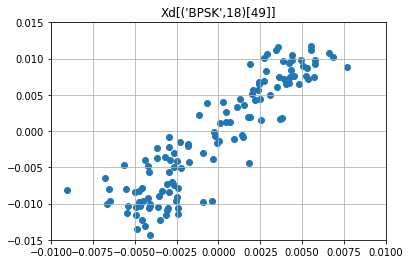

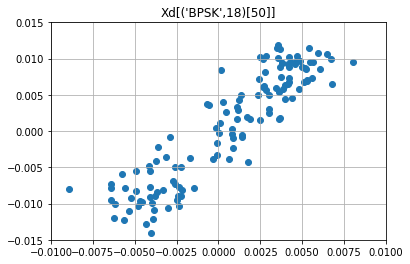

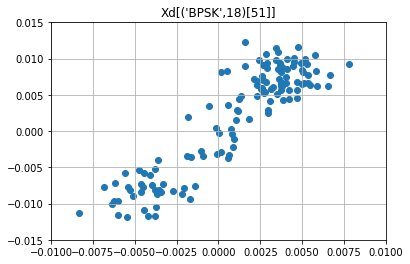

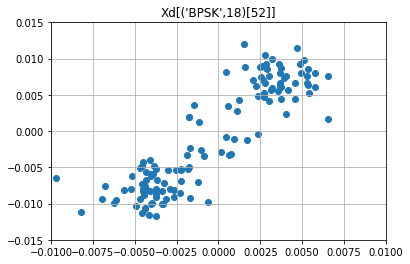

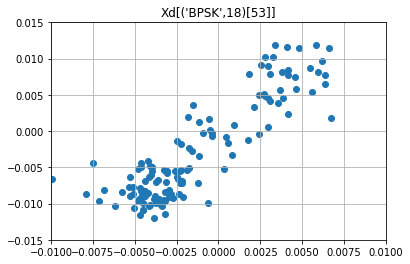

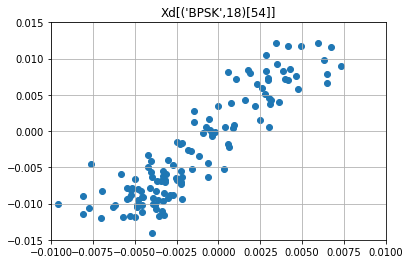

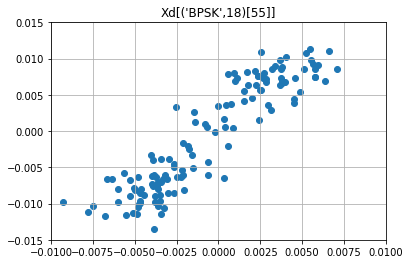

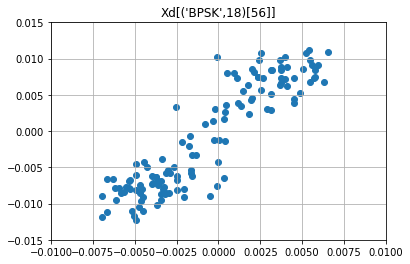

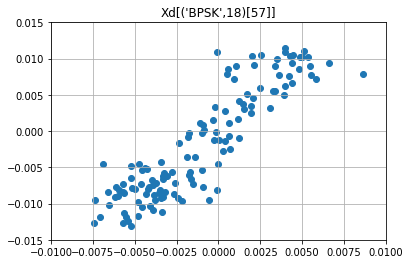

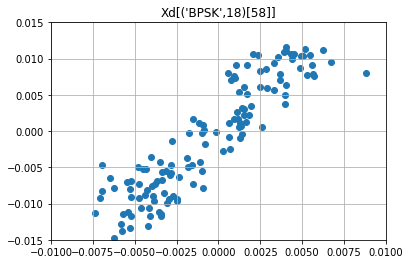

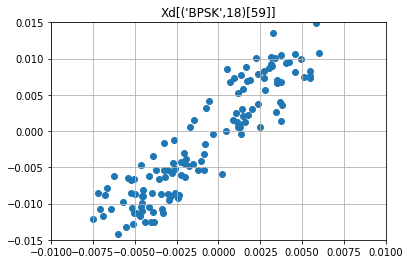

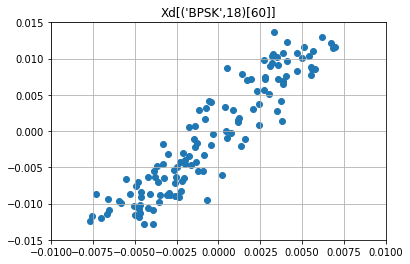

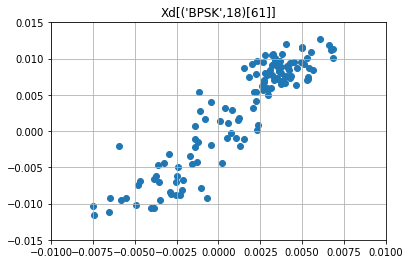

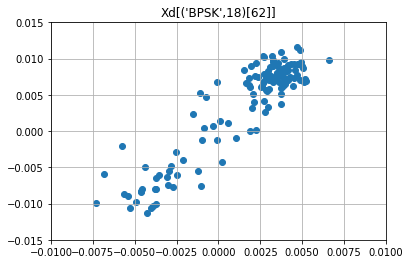

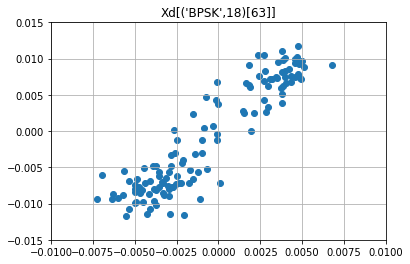

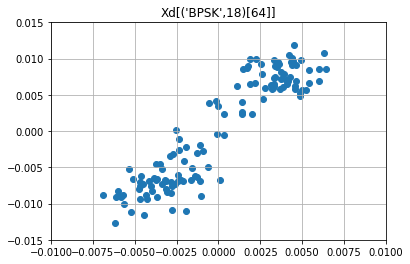

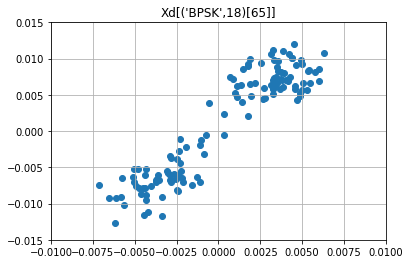

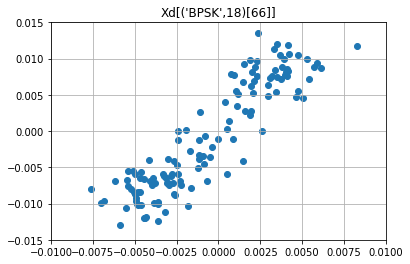

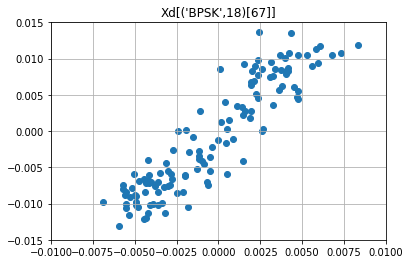

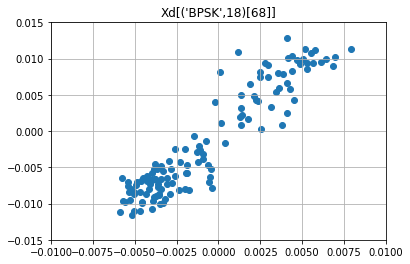

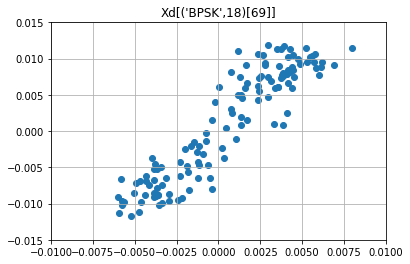

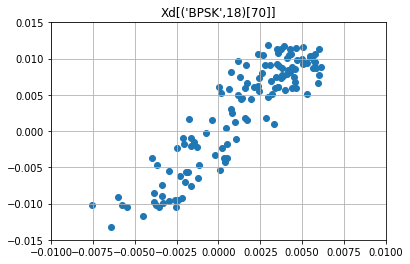

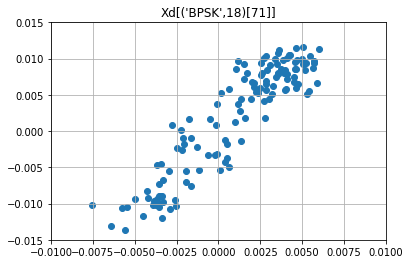

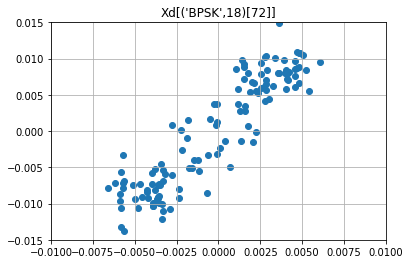

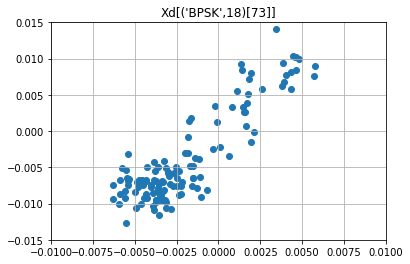

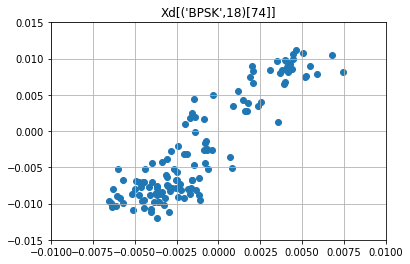

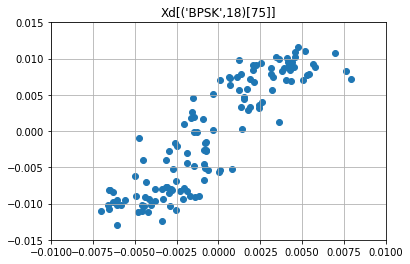

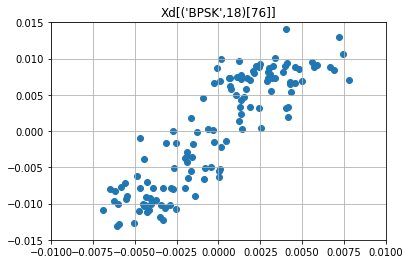

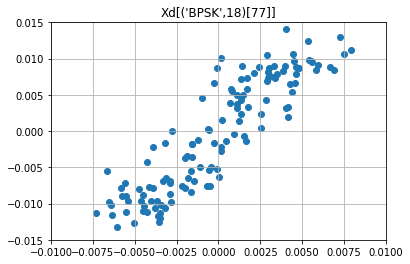

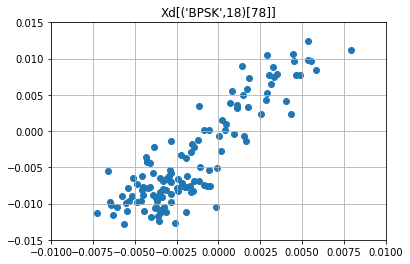

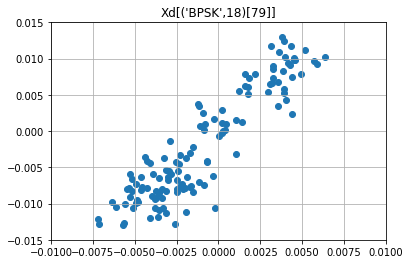

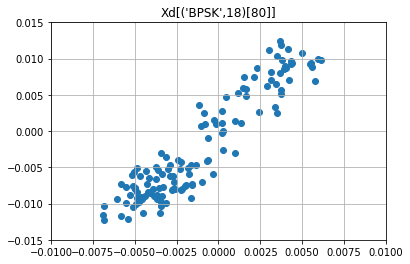

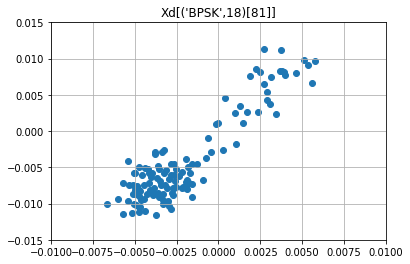

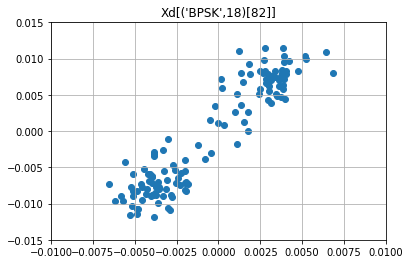

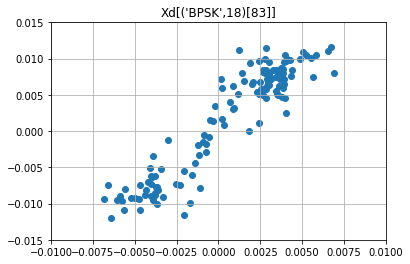

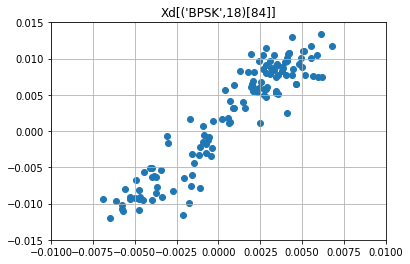

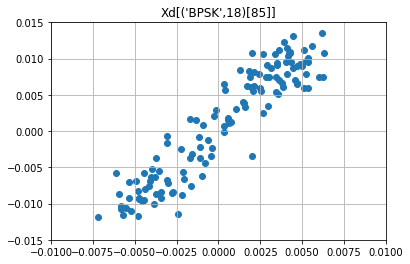

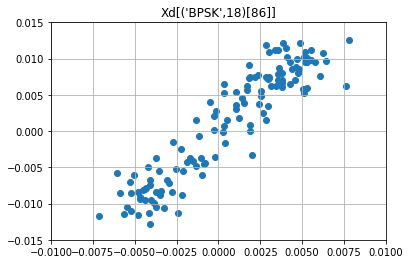

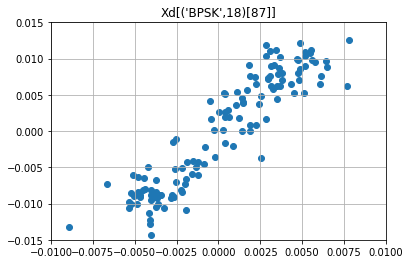

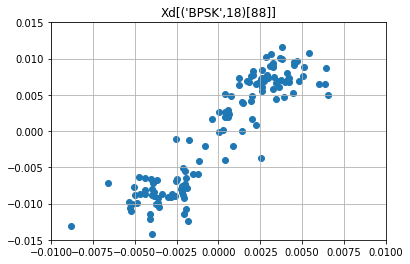

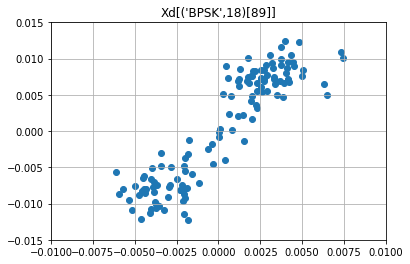

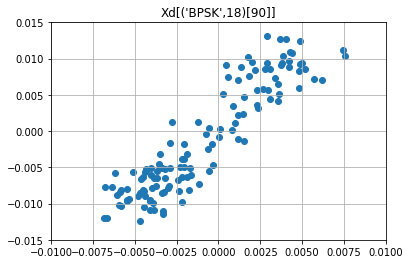

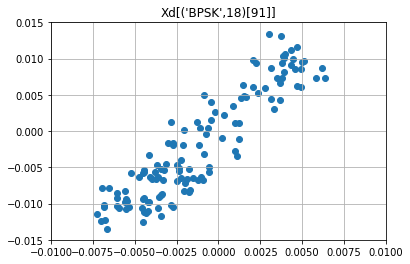

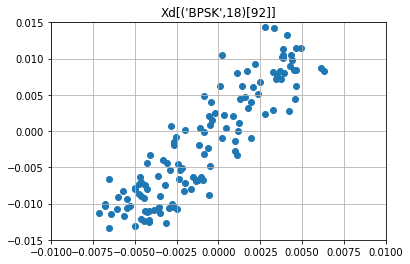

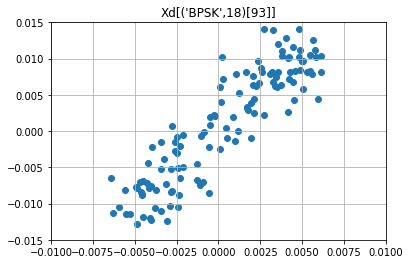

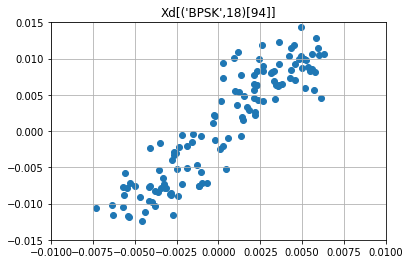

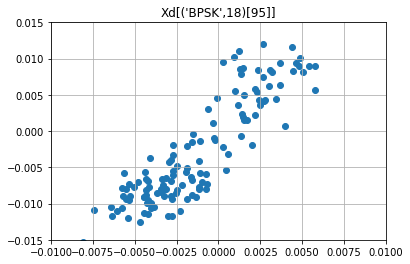

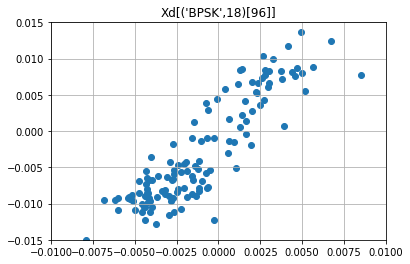

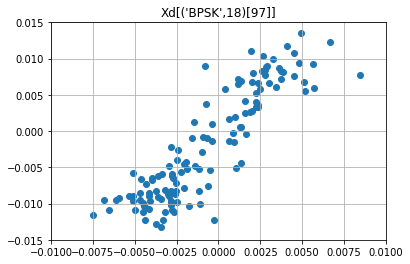

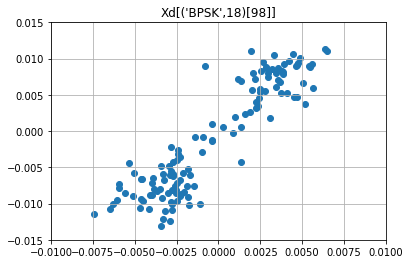

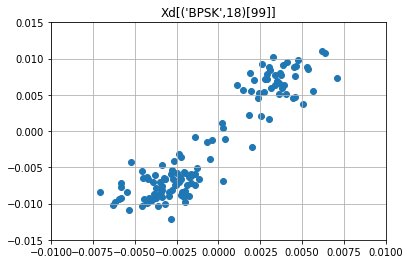

In [19]:
for i in range(100):
    x_values = list(Xd[('BPSK',6)][i][0])
    y_values = list(Xd[('BPSK',6)][i][1])
    plt.title(label='Xd[(\'BPSK\',18)[{0}]]'.format(i))
    plt.scatter(x_values, y_values)
    plt.grid(b=True)
    plt.axis([-0.01,0.01,-0.015,0.015])
    plt.show()

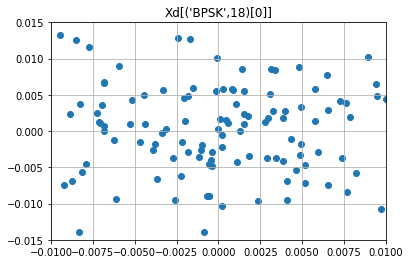

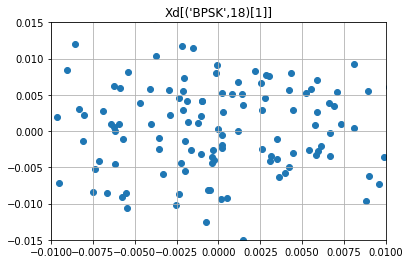

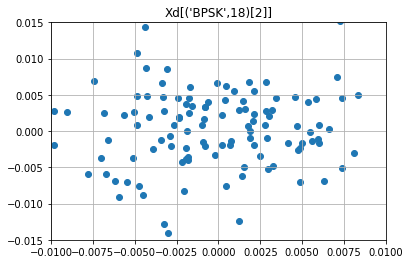

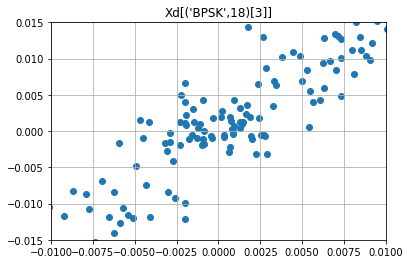

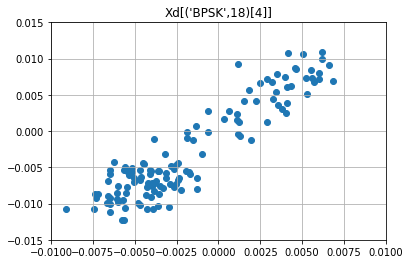

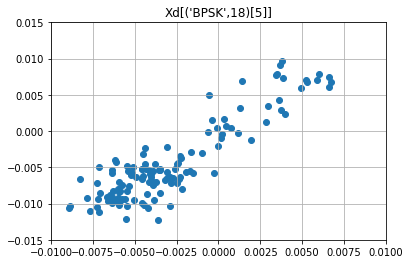

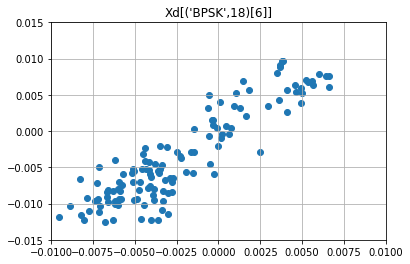

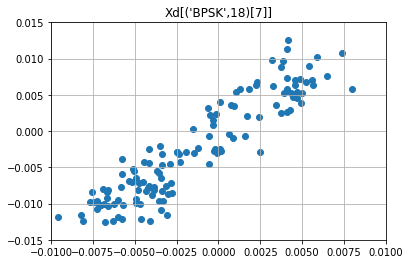

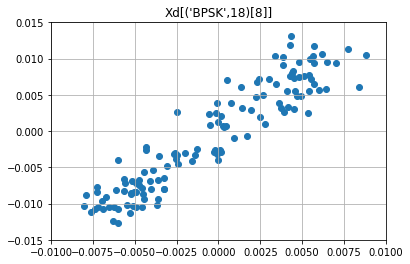

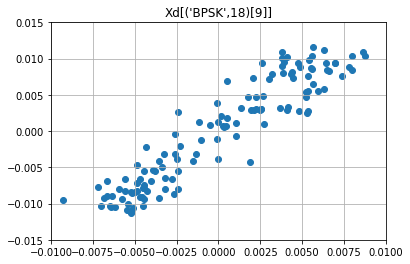

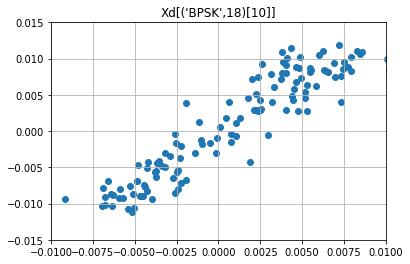

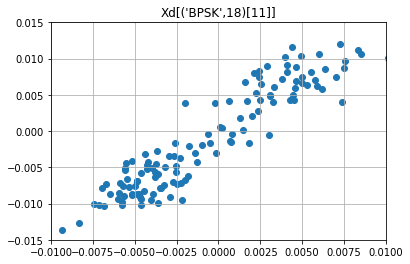

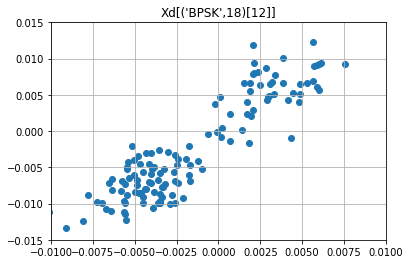

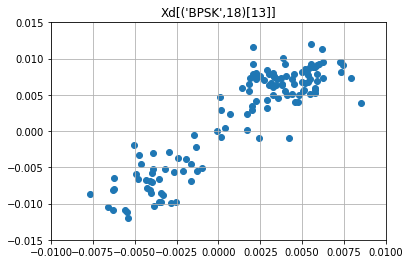

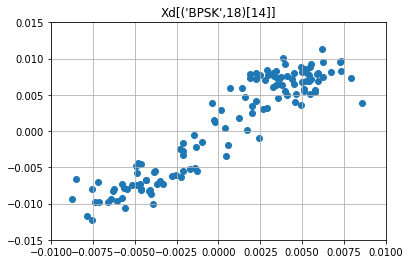

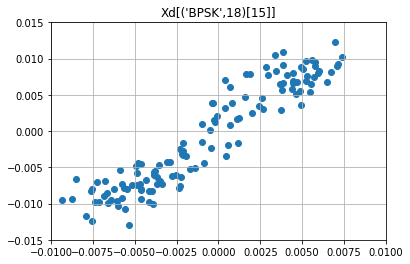

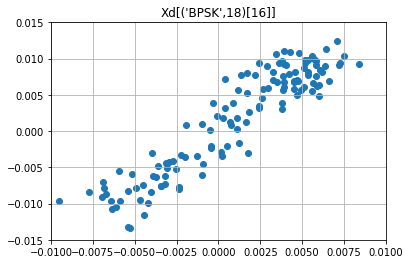

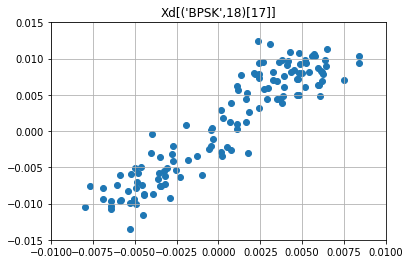

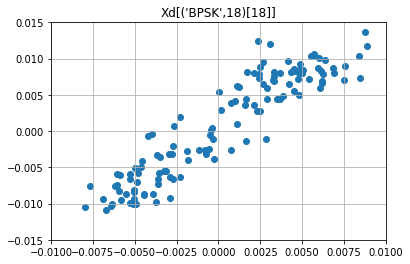

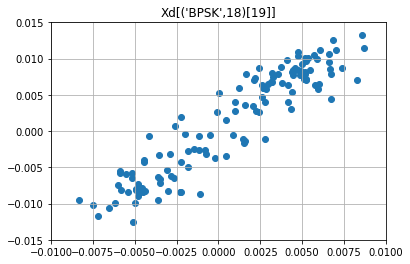

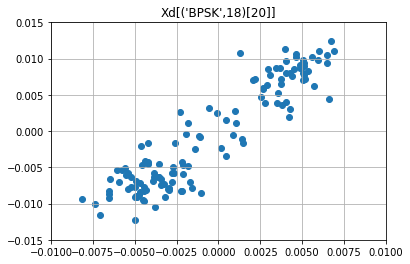

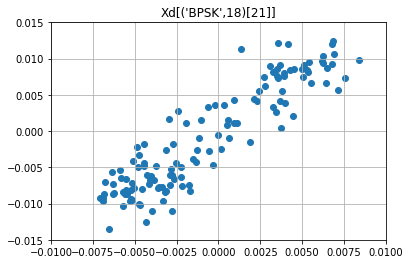

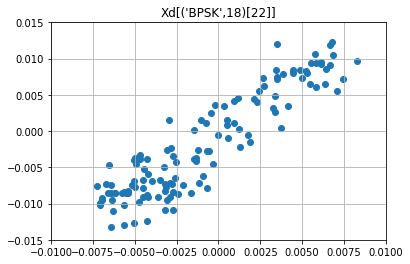

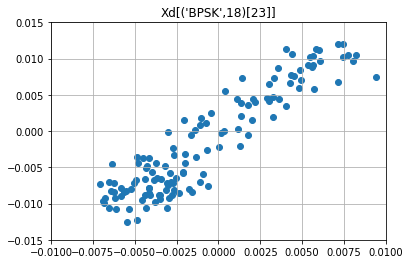

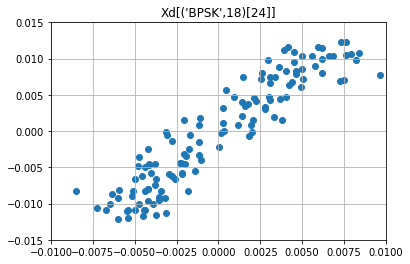

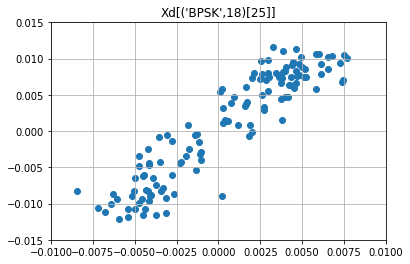

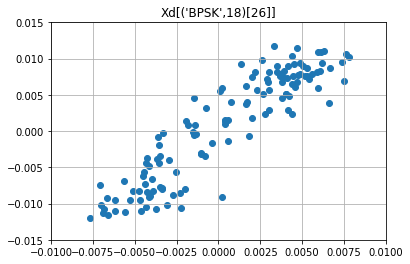

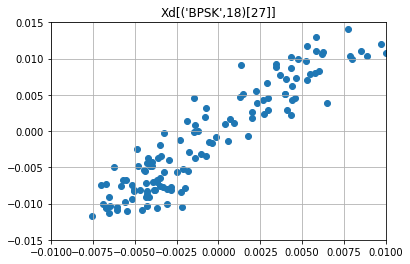

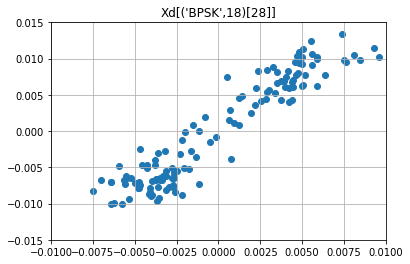

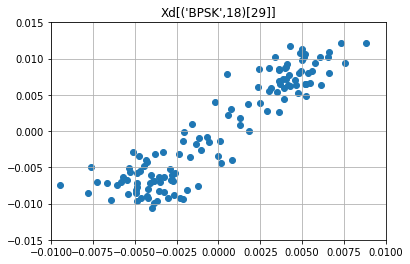

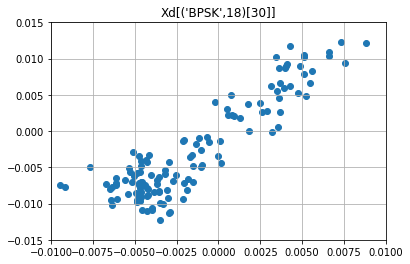

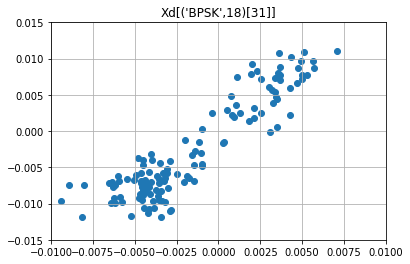

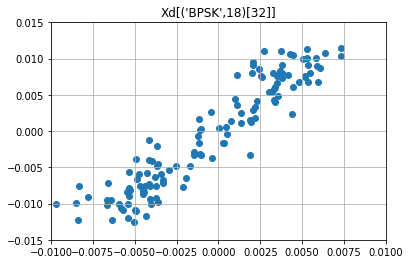

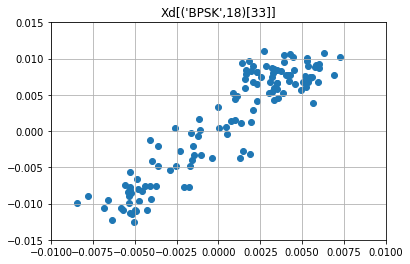

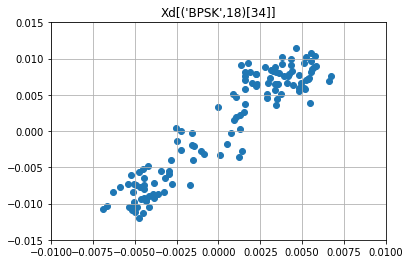

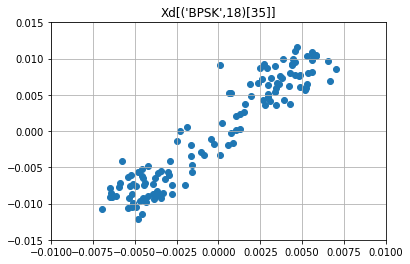

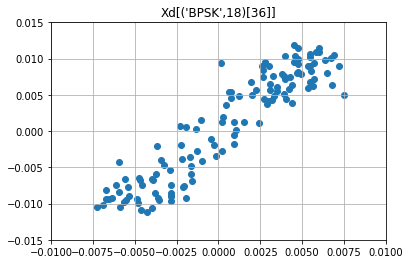

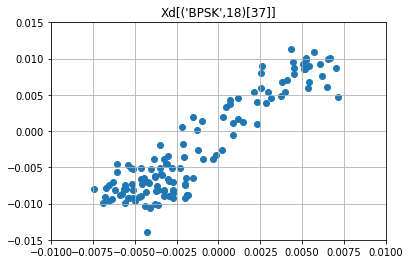

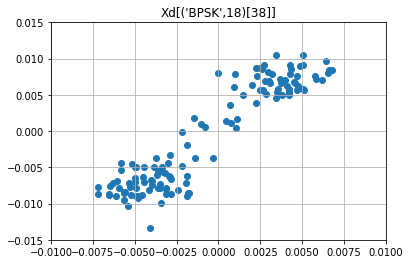

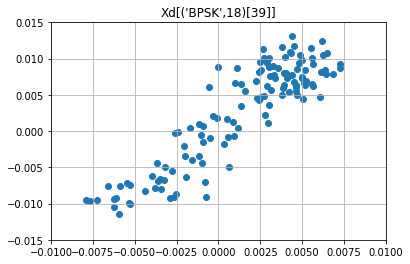

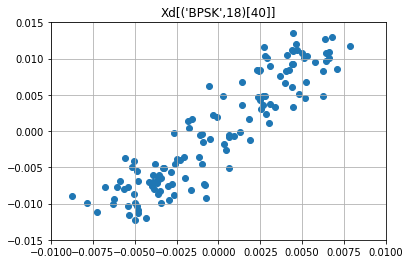

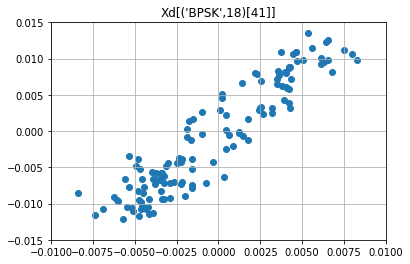

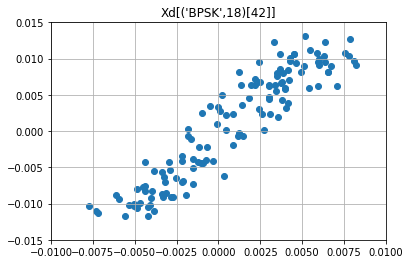

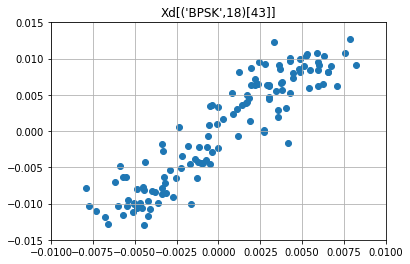

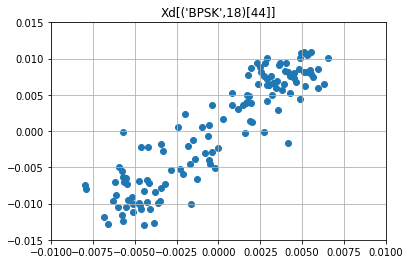

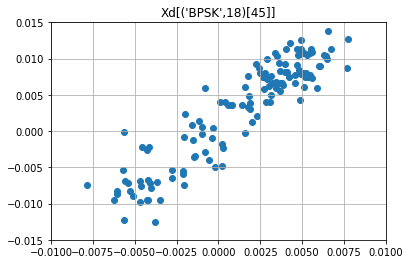

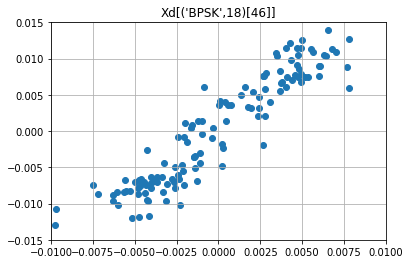

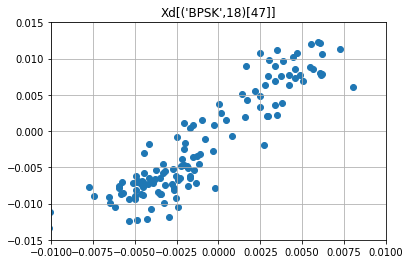

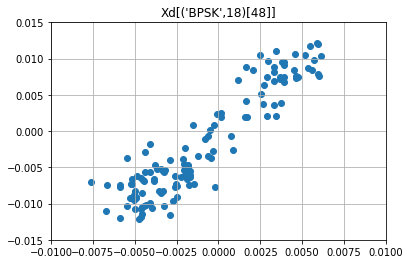

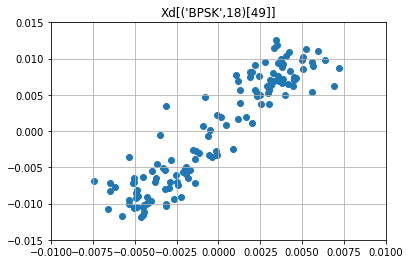

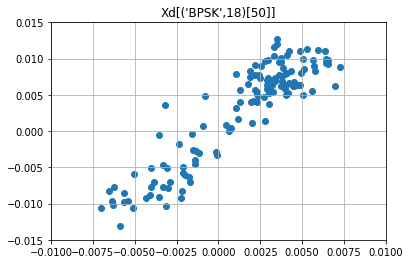

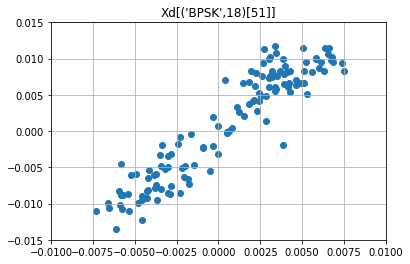

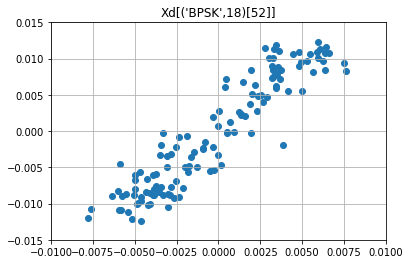

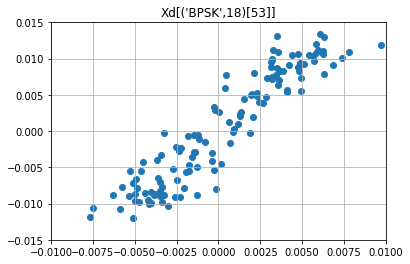

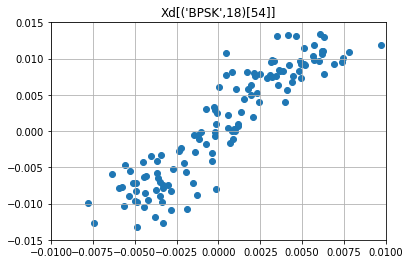

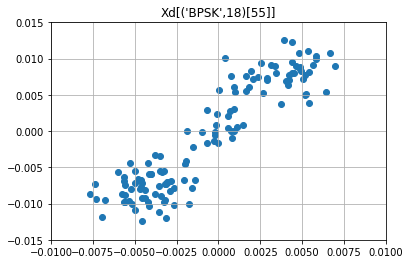

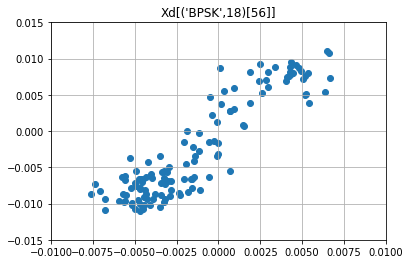

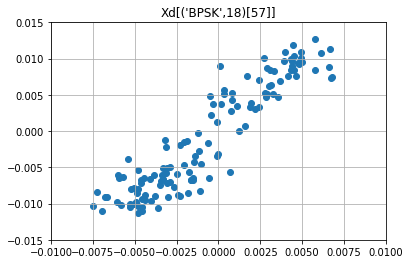

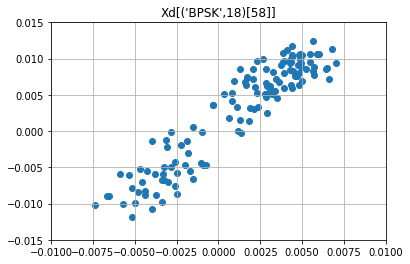

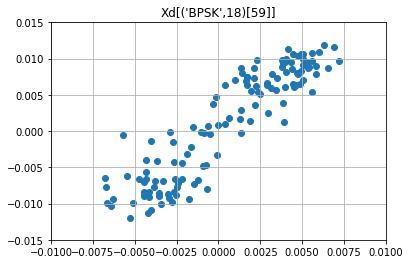

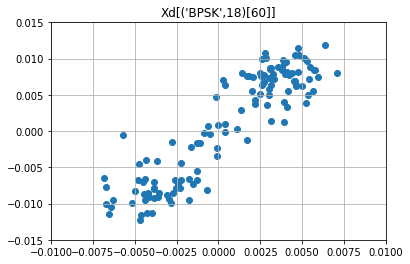

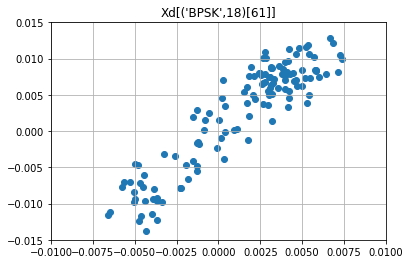

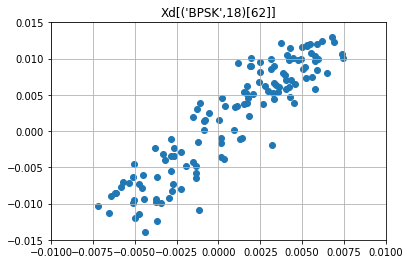

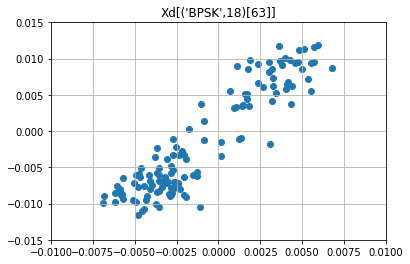

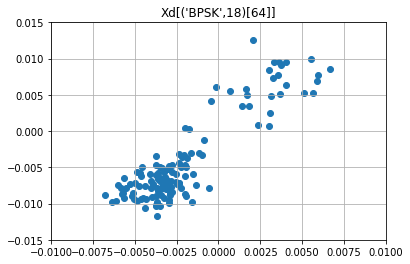

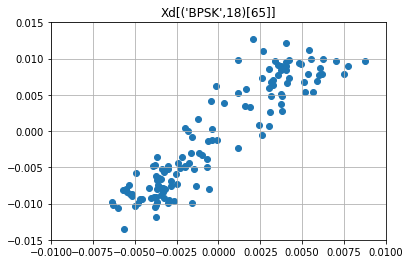

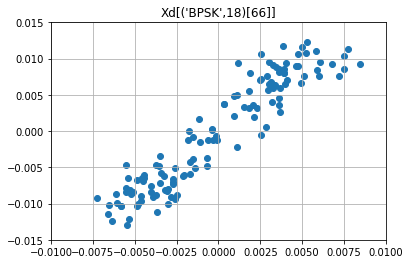

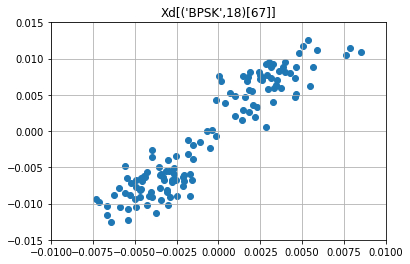

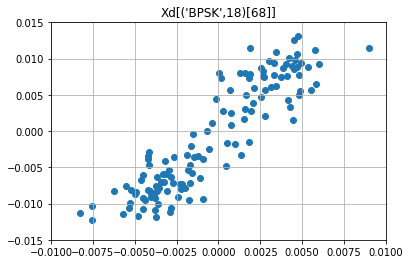

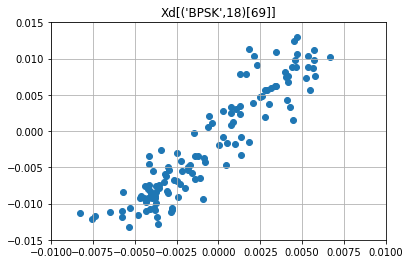

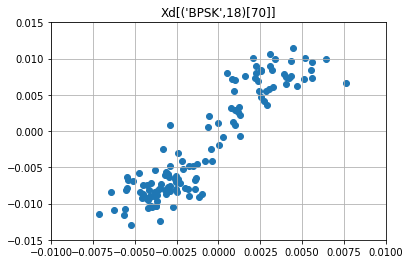

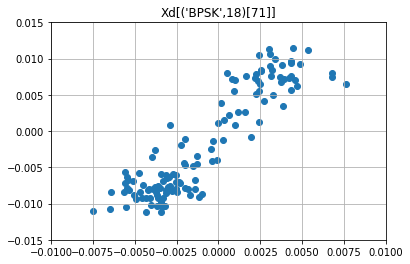

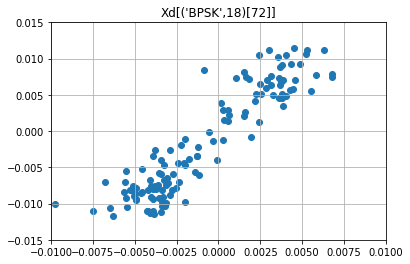

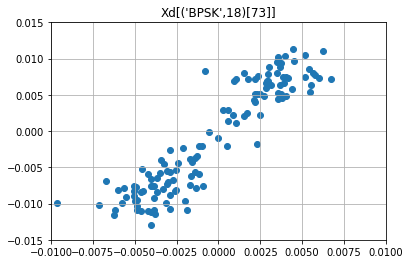

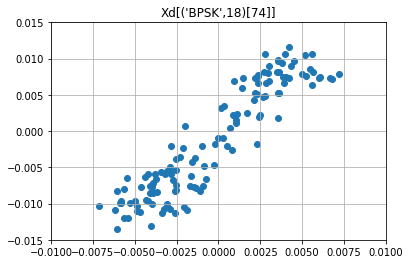

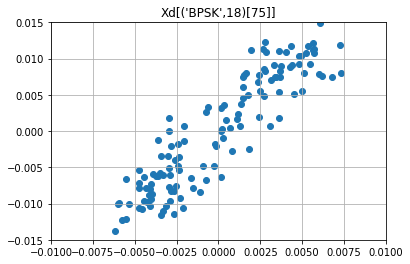

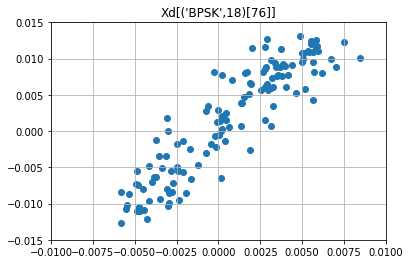

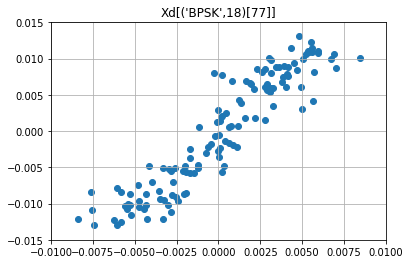

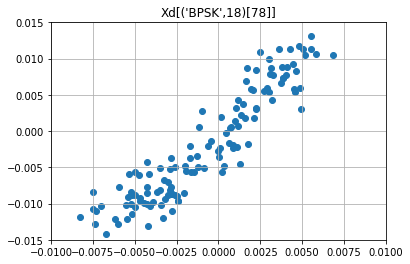

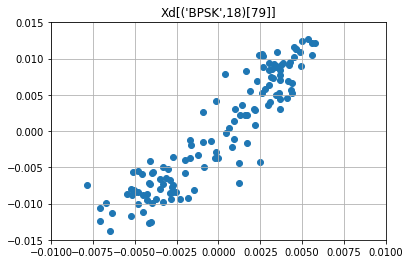

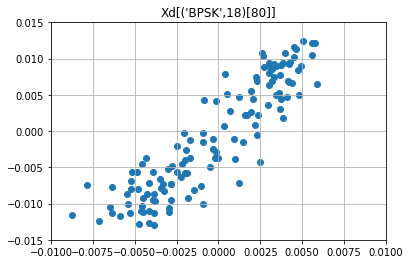

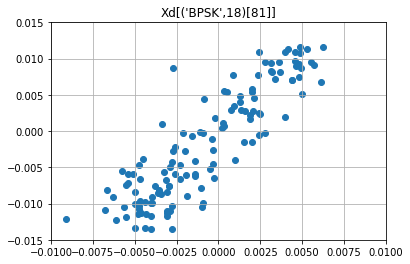

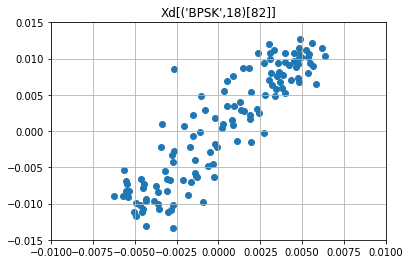

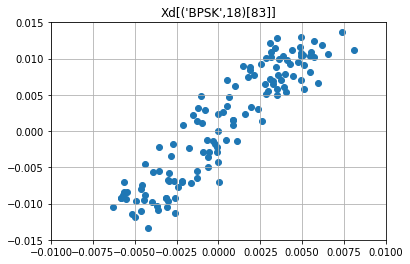

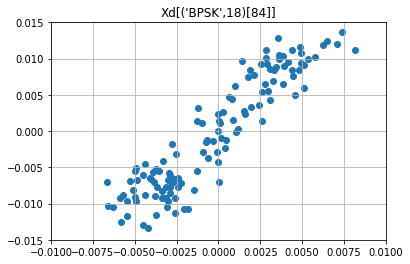

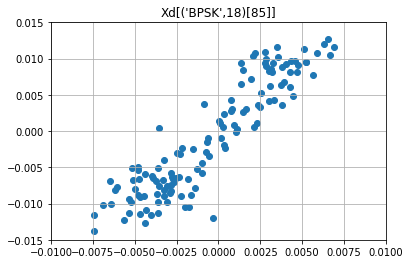

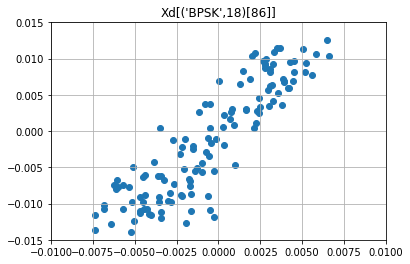

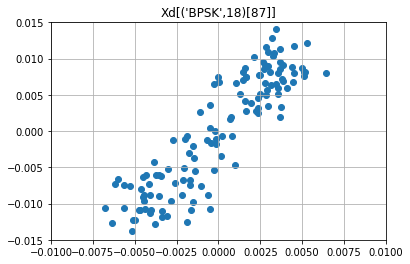

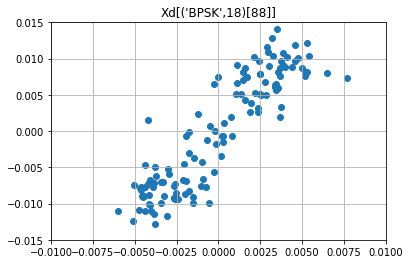

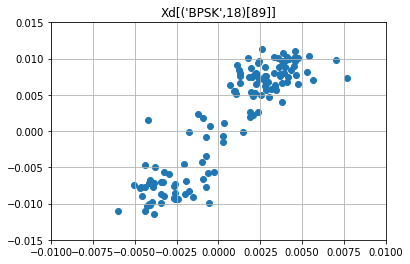

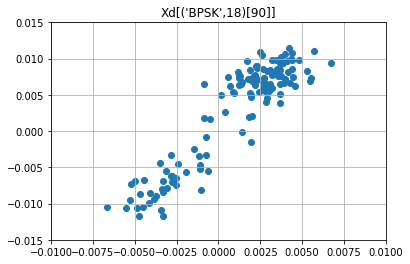

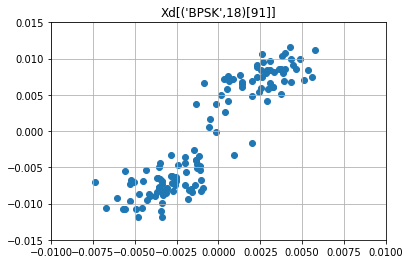

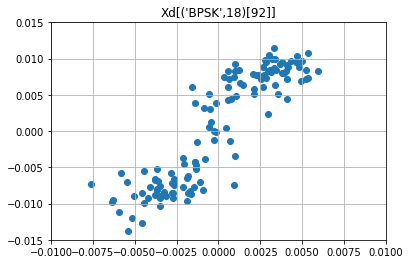

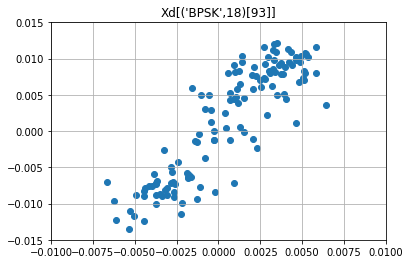

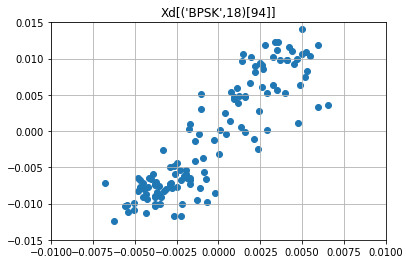

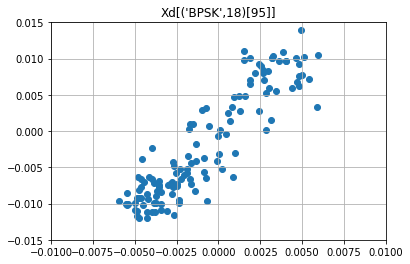

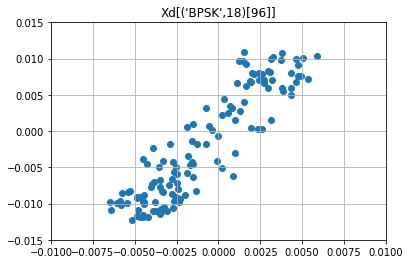

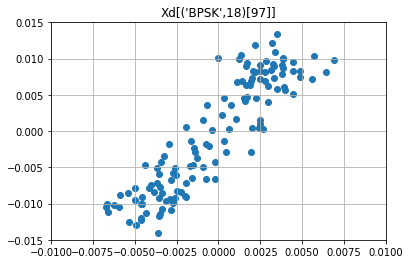

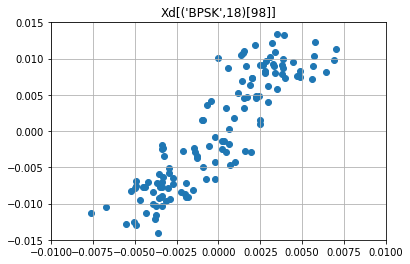

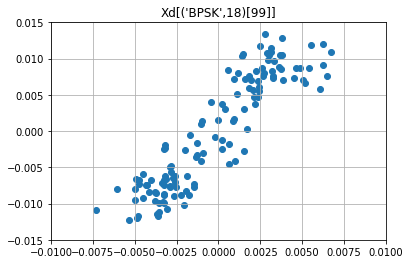

In [20]:
for i in range(100):
    x_values = list(Xd_all[('BPSK',6)][i][0])
    y_values = list(Xd_all[('BPSK',6)][i][1])
    plt.title(label='Xd[(\'BPSK\',18)[{0}]]'.format(i))
    plt.scatter(x_values, y_values)
    plt.grid(b=True)
    plt.axis([-0.01,0.01,-0.015,0.015])
    plt.show()